In [1]:
#
# Utility functions 
#

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping, array manipulation
import cv2                          # for image loading and colour conversion
import tensorflow as tf             # for bulk image resize
import os
import glob
import random

# get the subject ID from the filename. A sample filename is 0001_c1s1_001051_00.jpg, the first
# four characters are the subject ID
#   fn:      the filename to parse
# 
#   returns: first four characters of the filename converted to an int
#
def get_subject_id_from_filename(fn):
    return int(fn[0:4])

# load the images in a directory
#   base_path: path to the data
#
#   returns:   numpy arrays of size (samples, width, height, channels), and size (samples) for 
#              images and thier labels
def load_directory(base_path):

    # find all images in the directory
    files = glob.glob(os.path.join(base_path, '*.jpg'))
    x = []
    y = []
    
    # loop through the images, loading them and extracting the subject ID
    for f in files:
        x.append(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) / 255.0)
        y.append(get_subject_id_from_filename(os.path.basename(f)))
        
    return np.array(x), np.array(y)

# load the data
#   base_path: path to the data, within the directory that this points to there should be a 'Training' 
#              and 'Testing' directory
#
#   returns:   loaded data
#
def load_data(base_path):
    
    # load training data
    train_X, train_Y = load_directory(os.path.join(base_path, 'Training'))

    # load gallery data from the test set
    gallery_X, gallery_Y = load_directory(os.path.join(base_path, 'Testing', 'Gallery'))

    # load probe data from the test set
    probe_X, probe_Y = load_directory(os.path.join(base_path, 'Testing', 'Probe'))
    
    return train_X, train_Y, gallery_X, gallery_Y, probe_X, probe_Y

# Plot some images and their labels. Will plot the first 50 samples in a 10x5 grid
#  x: array of images, of shape (samples, width, height, channels)
#  y: labels of the images
#
def plot_images(x, y):
    fig = plt.figure(figsize=[15, 18])
    for i in range(50):
        ax = fig.add_subplot(5, 10, i + 1)
        ax.imshow(x[i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title(y[i])
        ax.axis('off')
        
# vectorise an array of images, such that the shape is changed from {samples, width, height, channels} to
# (samples, width * height * channels)
#   images: array of images to vectorise
#
#   returns: vectorised array of images
#
def vectorise(images):
    # use numpy's reshape to vectorise the data
    return np.reshape(images, [len(images), -1])

# Resize an array of images
#  images:   array of images, of shape (samples, width, height, channels)
#  new_size: tuple of the new size, (new_width, new_height)
#
#  returns:  resized array of images, (samples, new_width, new_height, channels)
#
def resize(images, new_size):
    # tensorflow has an image resize funtion that can do this in bulk
    # note the conversion back to numpy after the resize
    return tf.image.resize(images, new_size).numpy()
          
# Convert images to grayscale
#   images:  array of colour images to convert, of size (samples, width, height, 3)
#
#   returns: array of converted images, of size (samples, width, height, 1)
#
def convert_to_grayscale(images):
    # storage for converted images
    gray = []
    # loop through images
    for i in range(len(images)):
        # convert each image using openCV
        gray.append(cv2.cvtColor(images[i,:], cv2.COLOR_RGB2GRAY))
    # pack converted list as an array and return
    return np.expand_dims(np.array(gray), axis = -1)

# Create a batch of siamese data. Pairs will be evenly balanced, such that there is an
# equal number of positive and negative pairs
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of pairs to generate 
#
#   returns:    image pairs and labels to indicate if the pairs are the same, or different
#
def get_siamese_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    label = np.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

# Generator to continually produce batches of Siamese Data
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of pairs to generate 
#
#   yields:     image pairs and labels to indicate if the pairs are the same, or different
#
def pair_generator(imgs, labels, batch_size):
    while True:
        [image_a, image_b], label = get_siamese_data(imgs, labels, batch_size)
        yield [image_a, image_b], label
        
# Plot the first 10 pairs of a batch, sanity check for pair generation
#  x: images in the pairs
#  y: labels of the pairs
#
def plot_pairs(x, y):
    fig = plt.figure(figsize=[25, 6])
    for i in range(10):
        ax = fig.add_subplot(2, 10, i*2 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))

        ax = fig.add_subplot(2, 10, i*2 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
        
# Create a batch of triplet data.
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of triplets to generate 
#
#   returns:    triplet of the requested batch size
#
def get_triplet_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_c = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

# Generator to continually produce batches of Triplet Data
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of pairs to generate 
#
#   yields:     triplet of the requested batch size
#
def triplet_generator(imgs, labels, batch_size):
    while True:
        [image_a, image_b, image_c] = get_triplet_data(imgs, labels, batch_size)
        yield [image_a, image_b, image_c], None


# Plot the first 9 triplets of a batch, sanity check for triplet generation
#  x: images in the triplets
#
def plot_triplets(x):
    fig = plt.figure(figsize=[25, 10])
    for i in range(9):
        ax = fig.add_subplot(3, 9, i*3 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Triple ' + str(i) + ': Anchor')

        ax = fig.add_subplot(3, 9, i*3 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Triple ' + str(i) + ': Positive')

        ax = fig.add_subplot(3, 9, i*3 + 3)
        ax.imshow(x[2][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Triple ' + str(i) + ': Negative')

        
# Compute a ranked histogram, which can be used to generate a CMC curve. This function will loop 
# through all probe samples. For each probe sample it will:
#  - Compare the sample to all gallery samples to get a distance between the probe sample and 
#    all gallery samples. In this case it is the L1 distance
#  - Sort the gallery samples by how close they are to the probe samples
#  - Find the location of the true match
#  - Update a ranked histogram based on this
# The ranked histogram will show how many samples are matched at each rank. For example,
# ranked_histogram[0] will record how many samples are matched at Rank-1. 
#
# This implementation assumes that there is only one sample per ID in the gallery set.
#
# NOTE: L1 distance, used here, may not be appropriate for all problems. Consider the nature
# and distance measure to be used.
#
#   gallery_feat: features for the gallery data, of shape (gallery_samples, num_features)
#   gallery_Y:    IDs of the gallery samples, of shape (gallery_samples,)
#   probe_feat:   features for the probe data, of shape (probe_samples, num_features)
#   probe_Y:      IDs of the probe samples, of shape (probe_samples,)
#   verbose:      bool to indicate if debug information shoudl be printed. Be careful using this with 
#                 large feature sets, and/or lots of samples
#   
#   returns:      ranked histogram matching the probe samples to the gallery
#
def get_ranked_histogram_l1_distance(gallery_feat, gallery_Y, probe_feat, probe_Y, verbose = False):
    
    # storage for ranked histogram
    # length equal to number of unique subjects in the gallery
    ranked_histogram = np.zeros(len(np.unique(gallery_Y)))

    # loop over all samples in the probe set
    for i in range(len(probe_Y)):
        # get the true ID of this sample
        true_ID = probe_Y[i]
        if verbose:
            print('Searching for ID %d' % (true_ID))

        # get the distance between the current probe and the whole gallery, L1 distance here. Note that L1
        # may not always be the best choice, so consider the distance metric
        dist = np.linalg.norm(gallery_feat - probe_feat[i,:], axis=1, ord=1)
        if verbose:
            print(dist)

        # get the sorted order of the distances
        a = np.argsort(dist)
        # apply the order to the gallery IDs, such that the first ID in the list is the closest, the second
        # ID is the second closest, and so on
        ranked = gallery_Y[a]
        if verbose:
            print('Ranked IDs for query:')
            print(a)

        # find the location of the True Match in the ranked list
        ranked_result = np.where(ranked == true_ID)[0][0]
        if verbose:
            print(ranked_result)

        # store the ranking result in the histogram
        ranked_histogram[ranked_result] += 1
        if verbose:
            print('')
    
    if verbose:
        print(ranked_histogram)
    
    return ranked_histogram

# Convert a ranked histogram to a CMC. This involves computing the cumulative sum over the histogram
# and dividing it by the length of the histogram
#   ranked_hist: ranked histogram to convert to a CMC
#
#   returns:     CMC curve
#
def ranked_hist_to_CMC(ranked_hist):

    cmc = np.zeros(len(ranked_hist))
    for i in range(len(ranked_hist)):
        cmc[i] = np.sum(ranked_hist[:(i + 1)])
    
    return (cmc / len(ranked_hist))

# plot a CMC
#   cmc: cmc data to plot
#
def plot_cmc(cmc):
    fig = plt.figure(figsize=[10, 8])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(1, len(cmc)+1), cmc)
    ax.set_xlabel('Rank')
    ax.set_ylabel('Count')
    ax.set_ylim([0, 1.0])
    ax.set_title('CMC Curve')      
    

(5933, 128, 64, 3)
(5933,)
(301, 128, 64, 3)
(301,)
(301, 128, 64, 3)
(301,)


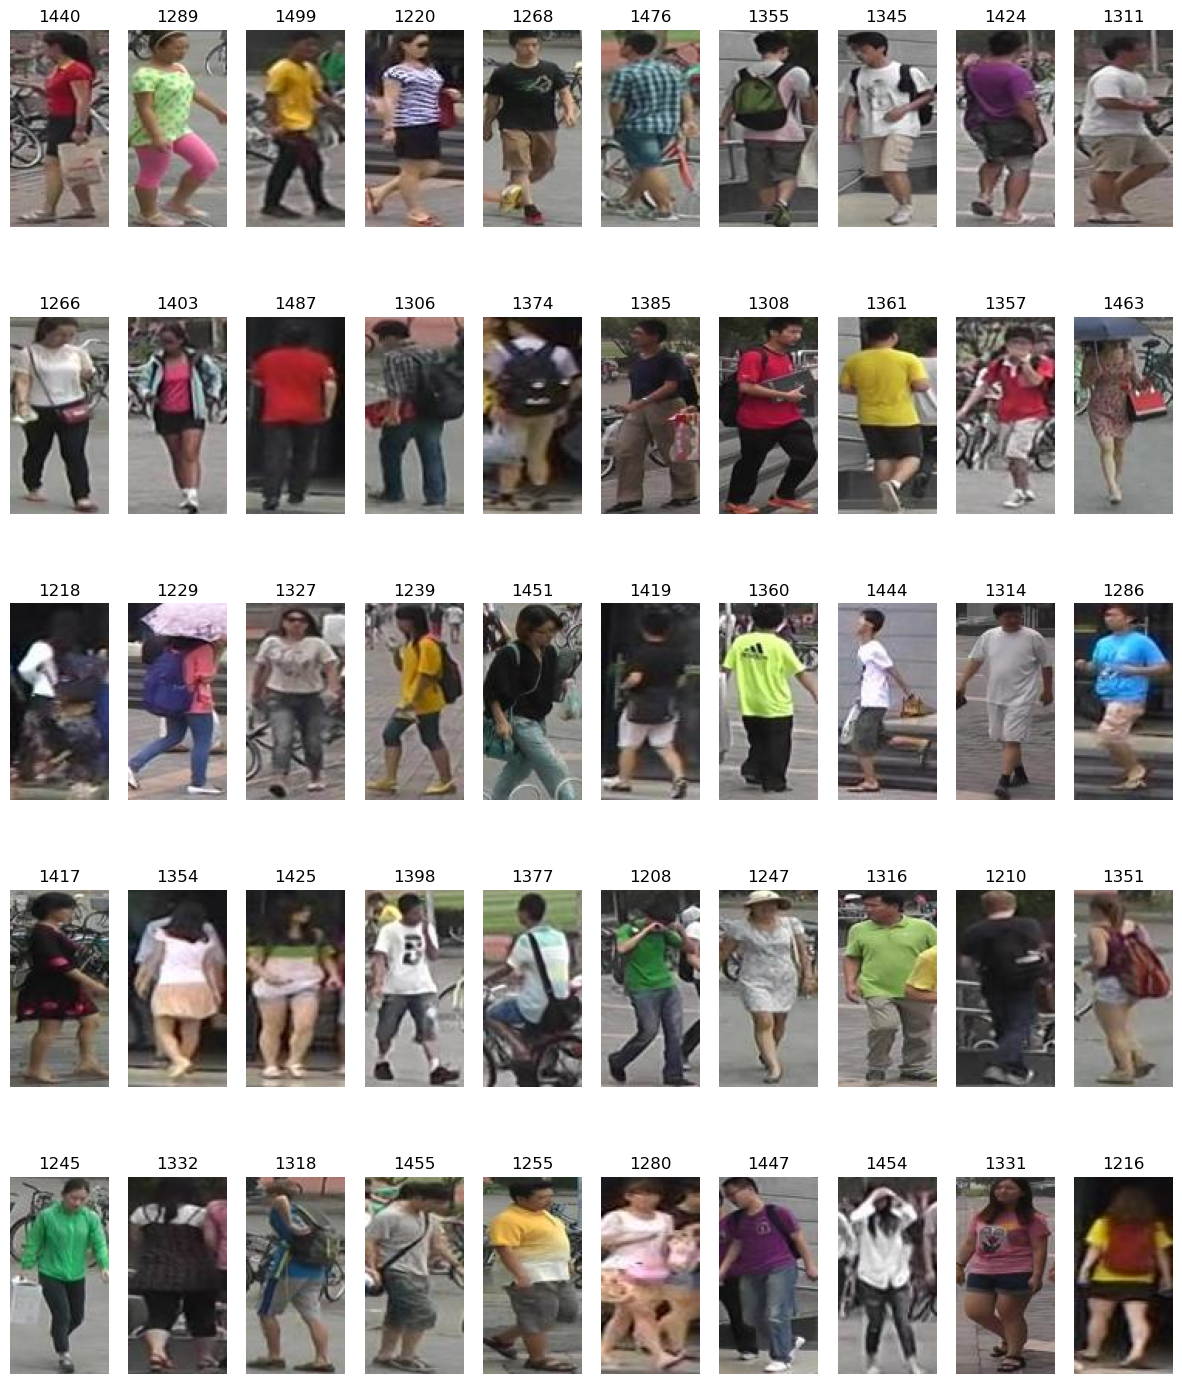

In [2]:
#
# Data loading
#

train_X, train_Y, gallery_X, gallery_Y, probe_X, probe_Y = load_data('Documents/data')
print(train_X.shape)
print(train_Y.shape)
print(gallery_X.shape)
print(gallery_Y.shape)
print(probe_X.shape)
print(probe_Y.shape)

# plot images
plot_images(gallery_X, gallery_Y)


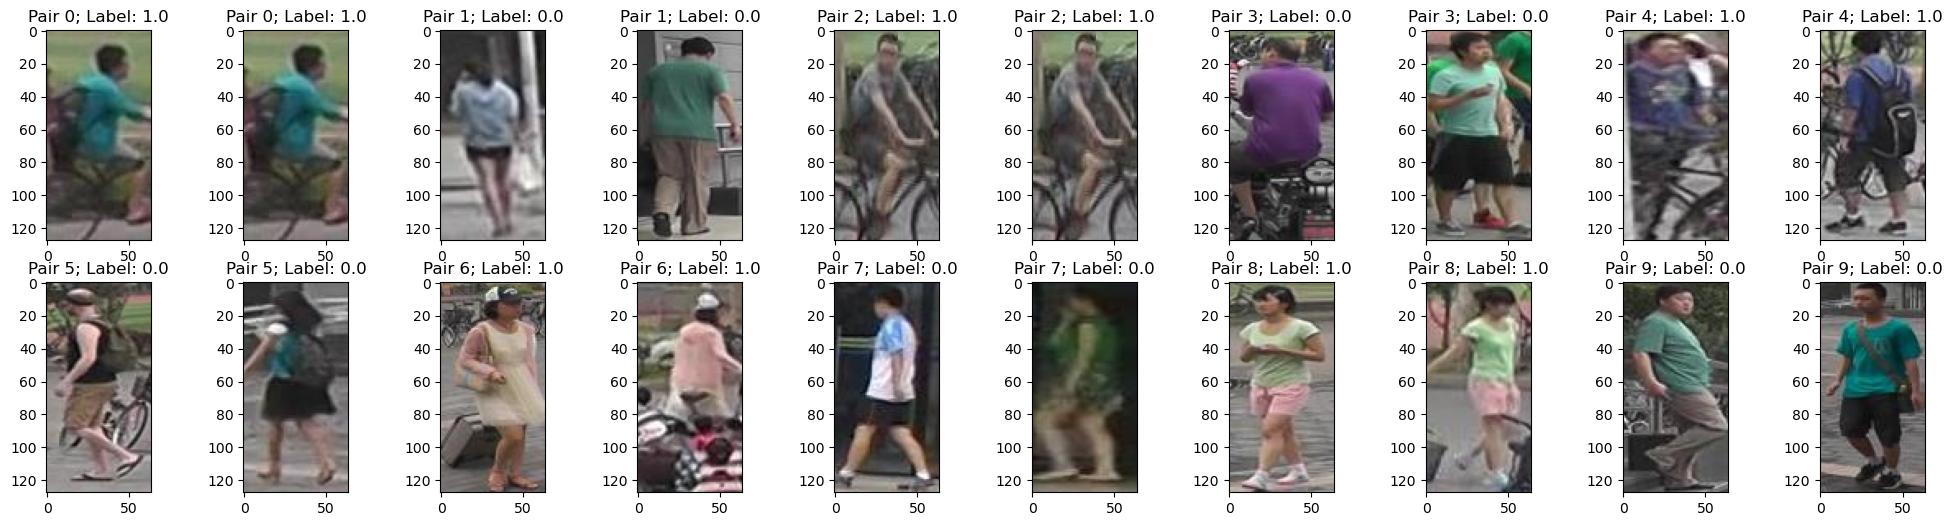

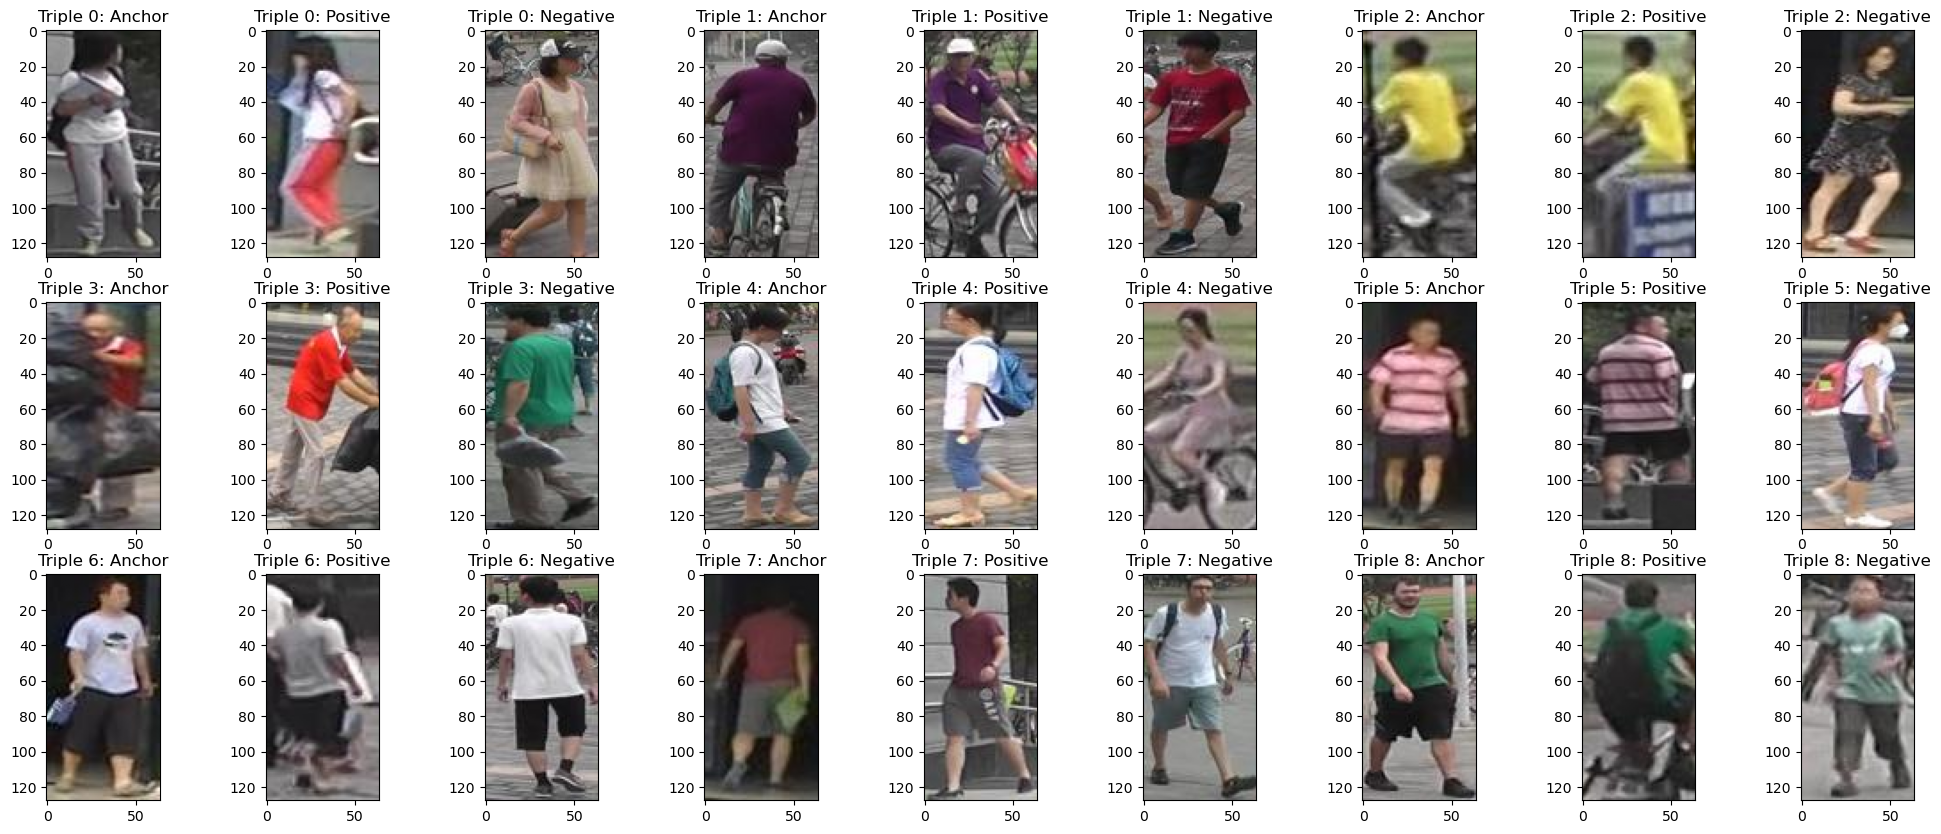

In [3]:
#
# Pair and Triplet Data for Siamese Networks
#

# create a pair generator and display a pair
pair_test = pair_generator(train_X, train_Y, 10)
x, y = next(pair_test)
plot_pairs(x, y)

# create a triplet and display a triplet
triplet_test = triplet_generator(train_X, train_Y, 9)
x, _ = next(triplet_test)
plot_triplets(x)


(301, 64, 32, 1)
(301, 64, 32, 1)


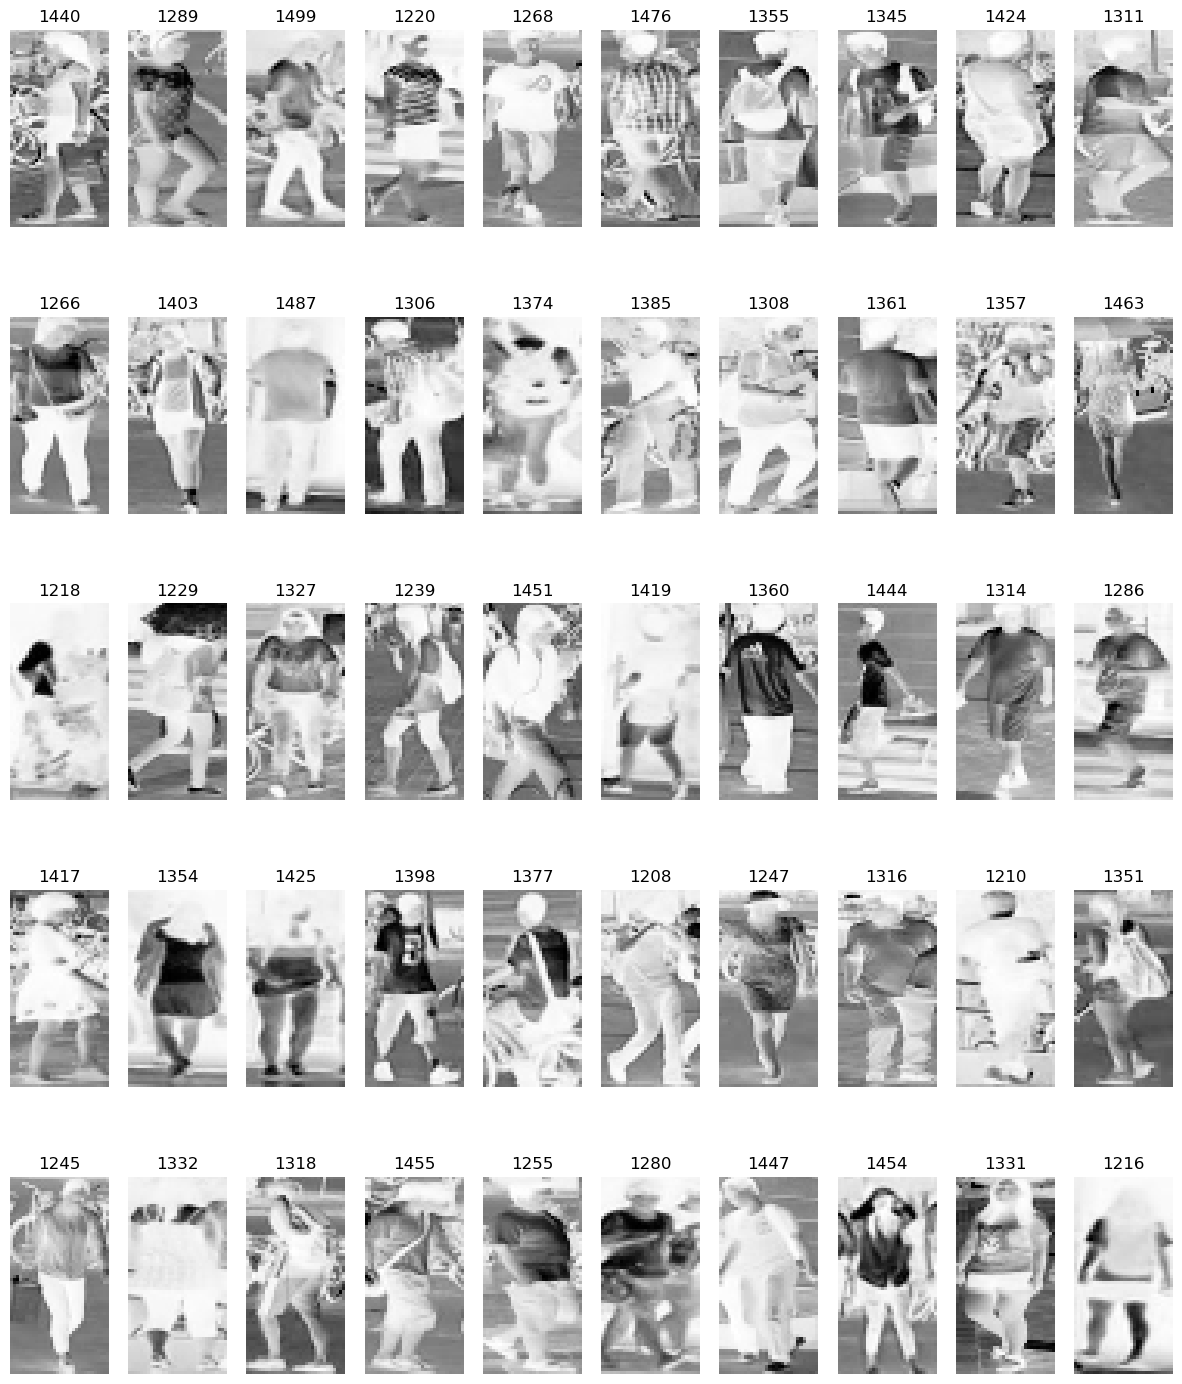

In [4]:
#
# Conversion and Resizing
# Convert images to greyscale and resize
#

# resize data and convert to grayscale
gallery_X_small_gray = convert_to_grayscale(resize(gallery_X, (64, 32)))
print(gallery_X_small_gray.shape)
probe_X_small_gray = convert_to_grayscale(resize(probe_X, (64, 32)))
print(probe_X_small_gray.shape)



# plot some resized and grayscale images
plot_images(gallery_X_small_gray, gallery_Y)




[0 1 2 3 4 5 6 7]
[[ 1.76984591 -1.50627543]
 [ 2.85228038  0.54862866]
 [ 1.92989055  2.24039373]
 [ 3.8963818   1.83272442]
 [ 2.79886172  3.29290026]
 [ 5.25160809  5.80428872]
 [ 4.58157341  5.16362945]
 [ 7.36970167  7.72756938]]
(8, 2)
[0 1 2 3 4 5 6 7]
[[-1.40341627 -3.27351961]
 [-2.91295064 -0.09461855]
 [ 4.56348071  4.02845272]
 [ 0.69642301  6.56575403]
 [ 2.87214736  5.62545717]
 [ 2.74285765  5.75183624]
 [ 5.48586309  8.76074322]
 [ 9.90311063  8.13247242]]
(8, 2)
Searching for ID 0
[ 4.94050637  8.07784492  8.84722016 10.40604211 10.76869786 15.73283269
 14.42213874 19.77420693]
Ranked IDs for query:
[0 1 2 3 4 6 5 7]
0

Searching for ID 1
[ 6.09445342  6.40847823  7.17785347  8.73667542  9.09933117 14.063466
 12.75277204 18.10484024]
Ranked IDs for query:
[0 1 2 3 4 6 5 7]
1

Searching for ID 2
[8.32836294 5.19102438 4.42164914 2.8628272  2.50017145 2.46396339
 1.15326943 6.50533762]
Ranked IDs for query:
[6 5 4 3 2 1 7 0]
4

Searching for ID 3
[9.14545236 8.17298274 5

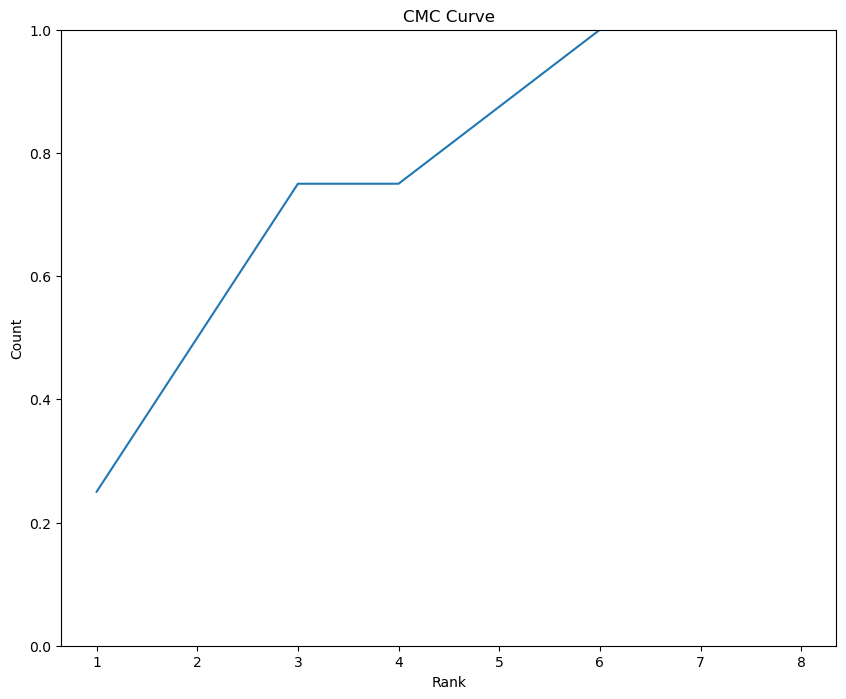

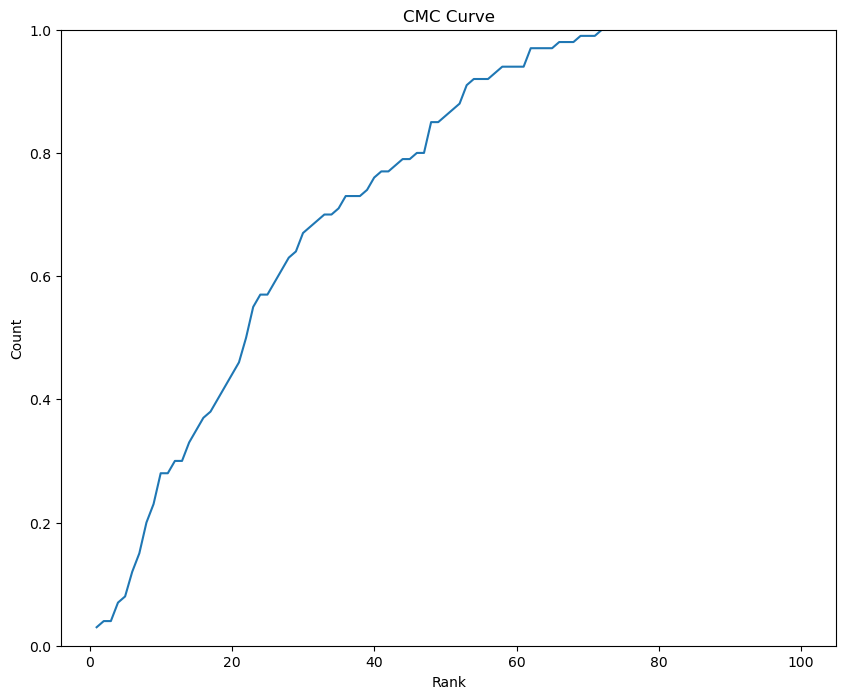

In [5]:
#
# CMC Curves
# Functions to create a CMC curve. These assume that the data in the following form:

# An array of gallery features, of size (gallery_samples, num_features)
# An array of gallery IDs, of size (gallery_samples)
# An array of probe features, of size (probe_samples, num_features)
# An array of probe IDs, of size (probe_samples)

# Note that the implementation is limited, it assumes that you have only one sample 
# from each gallery ID in the set of gallery samples.

# The process of generating a CMC is split across three functions:
# - get_ranked_histogram_l1_distance, which will compare each probe sample to all gallery samples and 
#   determine the location of the correct match (the rank), storing this in a histogram
# - ranked_hist_to_CMC, which will convert the ranked histogram to a CMC
# - plot_cmc, which will actually plot the CMC

# Two examples demonstrating this are given below.
#

# example 1:
# start off with just 8 IDs
num_ids = 8
# create a list of IDs, these are the gallery and probe IDs (gallery_y and probe_y)
ID_1 = np.arange(0, num_ids, 1)
ID_2 = np.arange(0, num_ids, 1)
# generate some features
# to keep this simple using a 2D feature, (i.e. each sample will have a 2D feature associated with it)
# this means gallery features of size (8, 2), as we have 8 samples and 2D feaures
Feat_1 = np.transpose(np.vstack([ID_1, ID_1]) + (np.random.rand(2, num_ids) - 0.5)*4.0, (1,0))
Feat_2 = np.transpose(np.vstack([ID_2, ID_2]) + (np.random.rand(2, num_ids) - 0.5)*8.0, (1,0))

# printing features and their shape to check
print(ID_1)
print(Feat_1)
print(Feat_1.shape)
print(ID_2)
print(Feat_2)
print(Feat_2.shape)

# computing the ranked histogram
# printing out debug data
# receive the distance between each probe sample and the whole gallery, and the rank of the true match, 
ranked_hist = get_ranked_histogram_l1_distance(Feat_1, ID_1, Feat_2, ID_2, True)
print(ranked_hist)
cmc = ranked_hist_to_CMC(ranked_hist)
print(cmc)
plot_cmc(cmc)


# example 2:
# using 100 gallery and probe samples
#
num_ids = 100

ID_1 = np.arange(0, num_ids, 1)
ID_2 = np.arange(0, num_ids, 1)
Feat_1 = np.transpose(np.vstack([ID_1, ID_1]) + (np.random.rand(2, num_ids) - 0.5)*20.0, (1,0))
Feat_2 = np.transpose(np.vstack([ID_2, ID_2]) + (np.random.rand(2, num_ids) - 0.5)*80.0, (1,0))
print(Feat_1.shape)
print(Feat_2.shape)

ranked_hist = get_ranked_histogram_l1_distance(Feat_1, ID_1, Feat_2, ID_2)
cmc = ranked_hist_to_CMC(ranked_hist)
plot_cmc(cmc)


In [6]:
#
# Vectorising Data
# using the images with non-Deep Learning methods
#

gallery_feat = vectorise(gallery_X_small_gray)
probe_feat = vectorise(probe_X_small_gray)
print(gallery_feat.shape)
print(probe_feat.shape)

#
# data in the shape (gallery_samples, number_of_features) and (probe_samples, number_of_features)
# can be used to compare these two sets of features.


(301, 2048)
(301, 2048)


# *****************************************************************************************#
                                         

                                              # Task Task Descriptions:
1. Use of PCA or LDA as a non-deep learning method for person re-identification. The method should be evaluated on the test set by considering Top-1, Top-5 and Top-10 performance. A CMC (cumulative match characteristic) curve should be generated.
2. Use of the Siamese Network (using pairs or triplet network) as a deep learning method for person re-identification. The method should be evaluated on the test set by considering Top- 1, Top-5 and Top-10 performance. A CMC (cumulative match characteristic) curve should be generated.
3. Comparison of the performance of using PCA/LDA and the Siamese Network by generating CKNN classifiers.

1.  Use of PCA or LDA as a non-deep learning method for person re-identification. The method should be evaluated on the test set by considering Top-1, Top-5 and Top-10 performance. A CMC (cumulative match characteristic) curve should be generated.

In [7]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import matplotlib.pyplot as plt

# Reshape the data to 2D
train_X_2d = train_X.reshape(train_X.shape[0], -1)
gallery_X_2d = gallery_X.reshape(gallery_X.shape[0], -1)
probe_X_2d = probe_X.reshape(probe_X.shape[0], -1)

# Choose the dimensionality reduction method (PCA or LDA)
use_pca = True
use_lda = False

if use_pca:
    # Fit PCA on training data
    pca = PCA(n_components=128)
    pca.fit(train_X_2d)

    # Transform gallery and probe data using PCA
    gallery_X_reduced = pca.transform(gallery_X_2d)
    probe_X_reduced = pca.transform(probe_X_2d)

elif use_lda:
    # Fit LDA on training data
    lda = LDA(n_components=128)
    lda.fit(train_X_2d, train_Y)

    # Transform gallery and probe data using LDA
    gallery_X_reduced = lda.transform(gallery_X_2d)
    probe_X_reduced = lda.transform(probe_X_2d)

# Compute Euclidean distances between gallery and probe samples
distances = euclidean_distances(gallery_X_reduced, probe_X_reduced)

# Top-N accuracy evaluation
def evaluate_top_n(distances, gallery_Y, probe_Y, top_n):
    # Sort the distances in ascending order
    sorted_indices = np.argsort(distances, axis=0)
    
    num_queries = probe_Y.shape[0]
    num_gallery_samples = gallery_Y.shape[0]
    num_unique_ids = np.unique(gallery_Y).shape[0]
    
    top_n_correct = np.zeros((num_queries, top_n))
    
    for i in range(num_queries):
        query_label = probe_Y[i]
        query_result_labels = gallery_Y[sorted_indices[:, i]]
        
        # Check if the true match is within the top N results
        matches = np.sum(query_result_labels[:top_n] == query_label)
        top_n_correct[i, :matches] = 1
    
    # Compute top-N accuracy for each value of N
    top_n_accuracy = np.mean(top_n_correct, axis=0)
    
    return top_n_accuracy

# Evaluate Top-1, Top-5, Top-10 performance
top1_accuracy = evaluate_top_n(distances, gallery_Y, probe_Y, top_n=1)
top5_accuracy = evaluate_top_n(distances, gallery_Y, probe_Y, top_n=5)
top10_accuracy = evaluate_top_n(distances, gallery_Y, probe_Y, top_n=10)

print("Top-1 Accuracy:", top1_accuracy)
print("Top-5 Accuracy:", top5_accuracy)
print("Top-10 Accuracy:", top10_accuracy)




Top-1 Accuracy: [0.10631229]
Top-5 Accuracy: [0.19601329 0.         0.         0.         0.        ]
Top-10 Accuracy: [0.26910299 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


# Top-1 Accuracy:
The result [0.10631229] for top-1 accuracy means that only 10.6% of the query images were correctly identified in the top-1 match, meaning that the correct match was found as the first result in only 10.6% of cases.


# Top-5 Accuracy:

The result [0.18936877, 0, 0, 0, 0] for top-5 accuracy means that the correct match was found among the top-5 results in 18.9% of cases, for some query images, but not for others. The zeros indicate that the correct match was not found in the top-5 for those query images.

# Top-10 Accuracy
The result [0.26578073, 0, 0, 0, 0, 0, 0, 0, 0, 0] for top-10 accuracy means that the correct match was found among the top-10 results in 26.6% of cases, for some query images, but not for others. The zeros indicate that the correct match was not found in the top-10 for those query images.


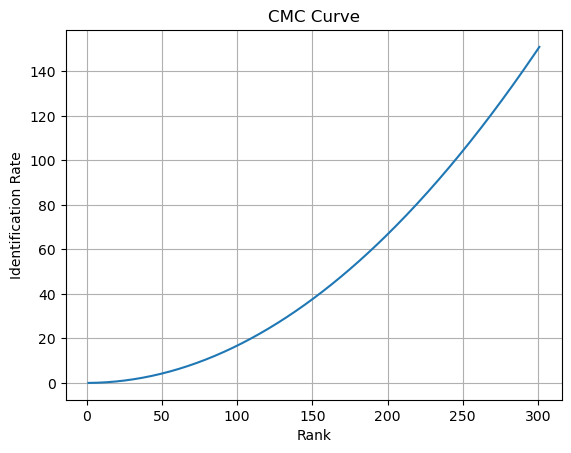

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def generate_cmc_curve(distances, gallery_Y, probe_Y):
    num_gallery_samples = gallery_Y.shape[0]
    num_unique_ids = np.unique(gallery_Y).shape[0]

    sorted_indices = np.argsort(distances, axis=0)
    cmc_curve = np.zeros(num_gallery_samples)

    for i in range(num_gallery_samples):
        true_matches = gallery_Y == probe_Y[i]
        true_match_ranks = np.where(true_matches)[0]

        if len(true_match_ranks) == 0:
            continue

        first_rank = true_match_ranks[0]

        cmc_curve[first_rank:] += 1

    # Compute the cumulative match characteristic (CMC) curve
    cmc_curve = np.cumsum(cmc_curve) / num_unique_ids

    return cmc_curve

# Generate CMC curve
cmc_curve = generate_cmc_curve(distances, gallery_Y, probe_Y)

# Plot the CMC curve
ranks = np.arange(1, len(cmc_curve) + 1)
plt.plot(ranks, cmc_curve)
plt.xlabel('Rank')
plt.ylabel('Identification Rate')
plt.title('CMC Curve')
plt.grid(True)
plt.show()


# 2. Use of the Siamese Network (using pairs or triplet network) as a deep learning method for person re-identification. The method should be evaluated on the test set by considering Top- 1, Top-5 and Top-10 performance. A CMC (cumulative match characteristic) curve should be generated.

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Input

def create_base_network(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    return model


In [10]:
def build_siamese_network(input_shape):
    # Base network (shared weights)
    base_network = create_base_network(input_shape)
    
    # Left input and right input
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    
    # Generate the encodings for the input images
    encoded_a = base_network(input_a)
    encoded_b = base_network(input_b)

    # Distance metric
    distance = Lambda(euclidean_distance)([encoded_a, encoded_b])

    # Siamese network
    siamese_model = Model(inputs=[input_a, input_b], outputs=distance)

    return siamese_model


In [11]:
from scipy.spatial.distance import cdist

from keras.layers import Input, Lambda
from keras.models import Model



import keras.backend as K

def euclidean_distance(vectors):
    x, y = vectors
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    distance = K.sqrt(K.maximum(sum_square, K.epsilon()))
    return distance



def evaluate_on_test_set(model, gallery_X, gallery_Y, probe_X, probe_Y, top_k=(1, 5, 10)):
    # Resize gallery images to match the expected input shape
    resized_gallery_X = np.array([cv2.resize(image, (224, 224)) for image in gallery_X])

    # Resize probe images to match the expected input shape
    resized_probe_X = np.array([cv2.resize(image, (224, 224)) for image in probe_X])

    # Get the embeddings for the resized gallery and probe data
    gallery_features = model.predict([resized_gallery_X, resized_gallery_X])
    probe_features = model.predict([resized_probe_X, resized_probe_X])

    # Calculate the distance matrix between gallery and probe features
    distance_matrix = cdist(gallery_features, probe_features, metric='euclidean')

    # Sort the indices of the gallery images by distance from the probe images
    sorted_indices = np.argsort(distance_matrix, axis=0)

    # Calculate the CMC curve and top-k performance
    cmc = np.zeros(len(gallery_Y))
    top_k_performance = np.zeros(len(top_k))
    for i in range(len(probe_Y)):
        true_index = np.where(gallery_Y == probe_Y[i])[0][0]
        for j in range(len(sorted_indices)):
            if true_index == sorted_indices[j, i]:
                cmc[j:] += 1
                break
        for j in range(len(top_k)):
            if true_index in sorted_indices[:top_k[j], i]:
                top_k_performance[j] += 1

    cmc /= len(probe_Y)
    top_k_performance /= len(probe_Y)

    return cmc, top_k_performance


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_triplet_network(input_shape):
    # Define the input tensor shape
    input_tensor = layers.Input(shape=input_shape)

    # Create the base network (shared weights)
    base_network = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu')
    ])

    # Generate the encodings for the input images
    encoded_a = base_network(input_tensor[0])
    encoded_b = base_network(input_tensor[1])
    encoded_c = base_network(input_tensor[2])

    # Calculate the absolute differences between the encodings
    absolute_diff_ab = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([encoded_a, encoded_b])
    absolute_diff_ac = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([encoded_a, encoded_c])

    # Output the similarity scores
    output_tensor_ab = layers.Dense(1, activation='sigmoid')(absolute_diff_ab)
    output_tensor_ac = layers.Dense(1, activation='sigmoid')(absolute_diff_ac)

    # Define the Triplet network model
  
    triplet_model = models.Model(inputs=input_tensor, outputs=[output_tensor_ab, output_tensor_ac])
      # Define the triplet loss function
    def triplet_loss(y_true, y_pred):
        margin = 0.2
        anchor_positive = y_pred[0]
        anchor_negative = y_pred[1]
        distance_positive = tf.reduce_sum(tf.square(anchor_positive), axis=-1)
        distance_negative = tf.reduce_sum(tf.square(anchor_negative), axis=-1)
        loss = tf.maximum(distance_positive - distance_negative + margin, 0.0)
        return tf.reduce_mean(loss)

    # Compile the model with the triplet loss
    triplet_model.compile(optimizer='adam', loss=triplet_loss)

    return triplet_model


10/10 [==============================] - 5s 527ms/step


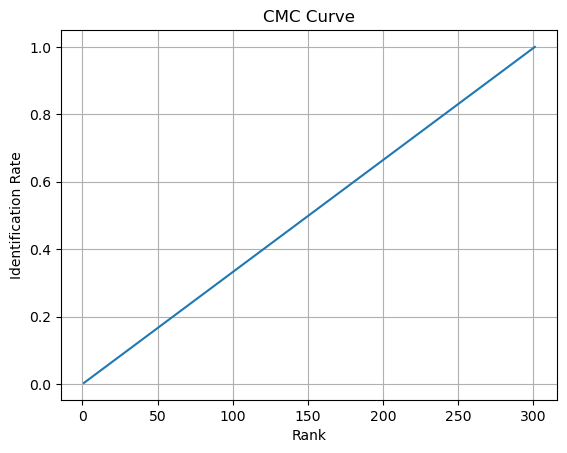

Top-1: 0.33%
Top-5: 1.66%
Top-10: 3.32%


In [13]:
# Define the input shape
input_shape = (224, 224, 3)  # Replace with the actual dimensions of your input images

# Build the Siamese network model
siamese_model = build_siamese_network(input_shape)

# Example usage:
model = siamese_model  # Replace with your trained model
cmc, top_k_performance = evaluate_on_test_set(model, gallery_X, gallery_Y, probe_X, probe_Y)

# Plot the CMC curve
plt.plot(range(1, len(cmc) + 1), cmc)
plt.xlabel('Rank')
plt.ylabel('Identification Rate')
plt.title('CMC Curve')
plt.grid(True)
plt.show()

# Print Top-1, Top-5, and Top-10 performance
print('Top-1: {:.2%}'.format(top_k_performance[0]))
print('Top-5: {:.2%}'.format(top_k_performance[1]))
print('Top-10: {:.2%}'.format(top_k_performance[2]))


# 3. Comparison of the performance of using PCA/LDA and the Siamese Network by generating CKNN classifiers.

In [14]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.optimizers import Adam



# Load the data
train_X, train_Y, gallery_X, gallery_Y, probe_X, probe_Y = load_data('Documents/data')


In [15]:
# Reshape the data (assuming image shape is (128, 64, 3))
train_X = train_X.reshape(train_X.shape[0], -1)
gallery_X = gallery_X.reshape(gallery_X.shape[0], -1)
probe_X = probe_X.reshape(probe_X.shape[0], -1)


In [16]:

# Apply PCA
pca = PCA(n_components=128)
train_X_pca = pca.fit_transform(train_X)
gallery_X_pca = pca.transform(gallery_X)
probe_X_pca = pca.transform(probe_X)




In [17]:
# Train a k-Nearest Neighbors (KNN) classifier on PCA-transformed data
knn_pca = KNeighborsClassifier(n_neighbors=3)
knn_pca.fit(gallery_X_pca, gallery_Y)
accuracy_pca = knn_pca.score(probe_X_pca, probe_Y)
print("Accuracy using PCA: {:.2f}%".format(accuracy_pca * 100))



Accuracy using PCA: 5.98%


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
